In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sys

In [40]:
file_two = "SFA Craft Demo and Case Study - Huffman.csv"
SFA_comp_df = pd.read_csv(file_two)
# SFA_comp_df = SFA_comp_df.drop(SFA_comp_df.columns[['opendate', 'IsValid', 'IsConnected', 'Personal', 'Reputation Level']], axis = 1, inplace = True)
# SFA_comp_df = SFA_comp_df.drop('ReceivingMail', 'Type', 'Volume Score', 'Result Number', 'EmailDays', axis = 1)
# SFA_comp_df.head()


SFA_comp_df = SFA_comp_df[['ID','BAD','opendate','AreaCode','EAScore', 'IdentityRank', 'DeviceBrowserType', 'IpAddressLocCity', 'IpAddressLocCountry']]
SFA_comp_df = SFA_comp_df.drop('opendate', axis=1)
SFA_comp_df.head()

,ID,BAD,AreaCode,EAScore,IdentityRank,DeviceBrowserType,IpAddressLocCity,IpAddressLocCountry
0,134457,1,973,NaN,425.0,TRIDENT,NaN,UNITED STATES
1,6360592,0,310,930.0,652.0,TRIDENT,AUSTIN,UNITED STATES
2,462987,0,502,704.0,683.0,CHROME,LOUISVILLE,UNITED STATES
3,309372,0,518,113.0,477.0,FIREFOX,SCHENECTADY,UNITED STATES
4,397009,1,713,NaN,587.0,FIREFOX,LOS ANGELES,UNITED STATES


In [41]:
ID_col = ['ID']
target_col = ["BAD"]
cat_cols = ['DeviceBrowserType','IpAddressLocCity','IpAddressLocCountry']
num_cols= list(set(list(SFA_comp_df.columns))-set(cat_cols)-set(ID_col)-set(target_col))

In [42]:
num_cat_cols = num_cols+cat_cols # Combined numerical and Categorical variables

#Create a new variable for each variable having missing value with VariableName_NA 
# and flag missing value with 1 and other with 0

for var in num_cat_cols:
    if SFA_comp_df[var].isnull().any()==True:
        SFA_comp_df[var+'_NA']=SFA_comp_df[var].isnull()*1

In [43]:
SFA_comp_df[num_cols] = SFA_comp_df[num_cols].fillna(SFA_comp_df[num_cols].median(),inplace=True)

SFA_comp_df[cat_cols] = SFA_comp_df[cat_cols].fillna(value = -9999)

SFA_comp_df.head()

/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,ID,BAD,AreaCode,EAScore,IdentityRank,DeviceBrowserType,IpAddressLocCity,IpAddressLocCountry,IdentityRank_NA,EAScore_NA,DeviceBrowserType_NA,IpAddressLocCity_NA,IpAddressLocCountry_NA
0,134457,1,973,495.0,425.0,TRIDENT,-9999,UNITED STATES,0,1,0,1,0
1,6360592,0,310,930.0,652.0,TRIDENT,AUSTIN,UNITED STATES,0,0,0,0,0
2,462987,0,502,704.0,683.0,CHROME,LOUISVILLE,UNITED STATES,0,0,0,0,0
3,309372,0,518,113.0,477.0,FIREFOX,SCHENECTADY,UNITED STATES,0,0,0,0,0
4,397009,1,713,495.0,587.0,FIREFOX,LOS ANGELES,UNITED STATES,0,1,0,0,0


In [44]:
#create label encoders for categorical features
for var in cat_cols:
 number = LabelEncoder()
 SFA_comp_df[var] = number.fit_transform(SFA_comp_df[var].astype('str'))

#Target variable is also a categorical so convert it
SFA_comp_df["BAD"] = number.fit_transform(SFA_comp_df["BAD"].astype('str'))
SFA_comp_df.head()

,ID,BAD,AreaCode,EAScore,IdentityRank,DeviceBrowserType,IpAddressLocCity,IpAddressLocCountry,IdentityRank_NA,EAScore_NA,DeviceBrowserType_NA,IpAddressLocCity_NA,IpAddressLocCountry_NA
0,134457,1,973,495.0,425.0,13,0,3,0,1,0,1,0
1,6360592,0,310,930.0,652.0,13,49,3,0,0,0,0,0
2,462987,0,502,704.0,683.0,1,538,3,0,0,0,0,0
3,309372,0,518,113.0,477.0,4,832,3,0,0,0,0,0
4,397009,1,713,495.0,587.0,4,537,3,0,1,0,0,0


In [45]:
features=list(set(list(SFA_comp_df.columns))-set(ID_col)-set(target_col))

df_0_7 = SFA_comp_df.sample(frac=0.7)

# Storing random 70% of data as the training set

df_train = SFA_comp_df.loc[SFA_comp_df.index.isin(df_0_7.index)]
#df_train.head()

df_train['is_train'] = np.random.uniform(0, 1, len(df_train)) <= .75
Train, Validate = df_train[df_train['is_train']==True], df_train[df_train['is_train']==False]


df_test = SFA_comp_df.loc[~SFA_comp_df.index.isin(df_0_7.index)]
df_test.head()
data_to_match = df_test['BAD'].tolist()
data_to_match

df_train['is_train'] = np.random.uniform(0, 1, len(df_train)) <= .75
#     print(df_train['is_train'])
Train, Validate = df_train[df_train['is_train']==True], df_train[df_train['is_train']==False]

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
x_train = Train[list(features)].values
y_train = Train["BAD"].values
x_validate = Validate[list(features)].values
y_validate = Validate["BAD"].values
x_test=df_test[list(features)].values

In [47]:
random.seed(100) # Read more about it
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [48]:
status = rf.predict_proba(x_validate)
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
#print(roc_auc)

final_status = rf.predict_proba(x_test)
df_test["BAD"]=final_status[:,1]

#df_test.to_csv('output.csv',columns=['ID','BAD'])
for i, frame in df_test['BAD'].iteritems():
    if frame > 0.5:
        df_test.loc[i, 'BAD'] = 1.0
    else:
        df_test.loc[i, 'BAD'] = 0.0
        
        
df_test['BAD'].head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


7     1.0
8     0.0
12    1.0
22    1.0
24    1.0
Name: BAD, dtype: float64

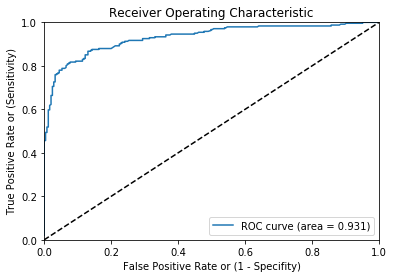

In [49]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [50]:
pred = df_test['BAD'].tolist()

In [51]:
true_positive = 0
true_negetive = 0
false_positive = 0
false_negetive = 0

for i in range(len(pred)):
    if (pred[i] == 1) and (data_to_match[i] == 1):
        true_positive+=1
    elif pred[i] == 0 and data_to_match[i] == 0:
        true_negetive+=1
    elif pred[i] == 1 and data_to_match[i] == 0:
        false_positive+=1
    elif pred[i] == 0 and data_to_match[i] == 1:
        false_negetive+=1
        
        
print("TRUE POSITIVE: ",true_positive)
print("FALSE POSITIVE: ",false_positive)
print("TRUE NEGETIVE: ",true_negetive)
print("FALSE NEGETIVE: ",false_negetive)

TRUE POSITIVE:  332
FALSE POSITIVE:  52
TRUE NEGETIVE:  376
FALSE NEGETIVE:  73


In [57]:
Precision = true_positive/(true_positive+false_positive)
Precision
recall = true_positive/(true_positive+false_negetive)
recall
F_score = (2*Precision*recall)/(Precision+recall)
F_score

0.8415716096324461

In [56]:
result = []
for i in range(len(pred)):
    if pred[i] == data_to_match[i]:
        result.append('True')
    else:
        result.append('False')

In [53]:
c = 0
for i in range(len(result)):
    if result[i] == 'True':
        c+=1
        
c

708